In this project, we will forecast twelve-hours of traffic flow in a major U.S. metropolitan area. Time, space, and directional features provide the chance to model interactions across a network of roadways.

Files and Field Descriptions
train.csv - the training set, comprising measurements of traffic congestion across 65 roadways from April through September of 1991.
row_id - a unique identifier for this instance
time - the 20-minute period in which each measurement was taken
x - the east-west midpoint coordinate of the roadway
y - the north-south midpoint coordinate of the roadway
direction - the direction of travel of the roadway. EB indicates "eastbound" travel, for example, while SW indicates a "southwest" direction of travel.
congestion - congestion levels for the roadway during each hour; the target. The congestion measurements have been normalized to the range 0 to 100.
test.csv - the test set; you will make hourly predictions for roadways identified by a coordinate location and a direction of travel on the day of 1991-09-30.
sample_submission.csv - a sample submission file in the correct format
Source
This dataset was derived from the Chicago Traffic Tracker - Historical Congestion Estimates dataset.

In [2]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython import display
import datetime


plt.rcParams['axes.facecolor'] = '#0057b8' #blue
plt.rcParams['axes.prop_cycle'] = cycler(color = ['#ffd700']+ plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])


In [3]:
#Reading data

train = pd.read_csv('train.csv', index_col='row_id', parse_dates=['time'])

test = pd.read_csv('test.csv', index_col='row_id', parse_dates=['time'])

print(train.shape, test.shape)
train.head()

(848835, 5) (2340, 4)


,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01,0,0,EB,70
1,1991-04-01,0,0,NB,49
2,1991-04-01,0,0,SB,24
3,1991-04-01,0,1,EB,18
4,1991-04-01,0,1,NB,60


Geography.
There are 12 roadways, 8 directions and 65 combinations of roadway with direction. This means that on average, a roadway has between 5 and 6 directions. The code below shows this for the training data; the test data has the same geography. There are no missing values in this dataset.

In [4]:
#unique roadways
roadways = train[['x', 'y']].drop_duplicates()
display.display(roadways)

#unique directions
print('Unique directions:', train.direction.unique())

#Unique roadways with direction
road_dir = train[['x', 'y', 'direction']].drop_duplicates()
display.display(road_dir)

,x,y
row_id,,
0,0,0
3,0,1
7,0,2
11,0,3
17,1,0
23,1,1
27,1,2
33,1,3
39,2,0


Unique directions: ['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


,x,y,direction
row_id,,,
0,0,0,EB
1,0,0,NB
2,0,0,SB
3,0,1,EB
4,0,1,NB
...,...,...,...
60,2,3,NB
61,2,3,NE
62,2,3,SB


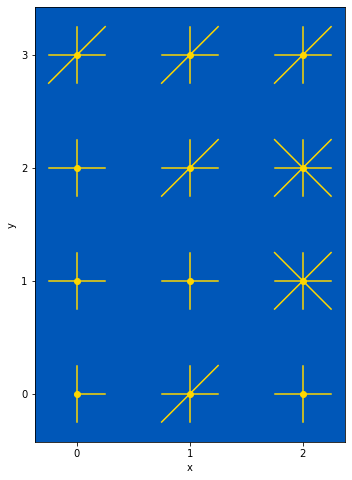

In [6]:
#plotting a geographical map of the 12 places with directions

dir_dict = {'EB': (1, 0), 'NB': (0, 1), 'SB': (0, -1), 'WB': (-1, 0), 'NE': (1, 1), 'SE': (1, -1), 'NW': (-1, 1), 'SW': (-1, -1)}

plt.figure(figsize=(8,8))
plt.scatter(roadways.x, roadways.y)
plt.gca().set_aspect('equal')
for _, x, y, d in road_dir.itertuples():
    dx, dy = dir_dict[d]
    dx, dy = dx/4, dy/4
    plt.plot([x, x+dx], [y, y+dy], color = '#ffd700')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True)) #only integer labels
plt.gca().yaxis.set_major_locator(MaxNLocator(integer = True)) #only integer labels

plt.xlabel('x')
plt.ylabel('y')
plt.show()

Insight:

As congestion is measured for certain points and directions in space, we can expect that these congestions predict future congestion at the nearest point in the given direction. For instance, congestion at (0, 1, eastbound) should be correlated with future congestion at (1, 1, ...).
The correlation goes both ways so that we can try to predict backwards: congestion at (1, 1, eastbound) should be correlated with past congestion at (0, 1, ...).
At first sight, it is unclear whether we need the geography at all: A simple approach for the competition would be ignoring the geography and creating 65 independent time series.
Another simple approach is one-hot encoding the 65 position/direction combinations and using them as features.
Although the y coordinate in the diagram grows from bottom to top (south to north), we can't take this for granted. Maybe it should grow from top to bottom.


Time
There are 13059 time values in the training data. As 13059 * 65 = 848835, i.e. the length of the train dataframe, we know that at every point in time, the congestion is known for all 65 roadways.

In [7]:
unique_times = train.time.unique()

print(unique_times.shape)

(13059,)


All training timestamps are between 1991-04-01 00:00 and 1991-09-30 11:40. The test timestamps cover the half day from 1991-09-30 12:00 through 1991-09-30 23:40, which is a Monday.

The difference between successive training timestamps is almost always 20 minutes, except for the 28 timestamps in the following list:

In [8]:
print(unique_times.min(), unique_times.max())
print(test.time.min(), test.time.max())
print(np.diff(unique_times)[0])
unique_times[1:][np.diff(unique_times) != np.diff(unique_times)[0]]

1991-04-01T00:00:00.000000000 1991-09-30T11:40:00.000000000
1991-09-30 12:00:00 1991-09-30 23:40:00
1200000000000 nanoseconds


array(['1991-04-20T19:20:00.000000000', '1991-04-24T06:20:00.000000000',
       '1991-05-04T22:00:00.000000000', '1991-05-18T19:40:00.000000000',
       '1991-05-31T03:20:00.000000000', '1991-06-15T20:40:00.000000000',
       '1991-07-18T20:20:00.000000000', '1991-07-20T19:40:00.000000000',
       '1991-08-08T14:20:00.000000000', '1991-08-16T19:00:00.000000000',
       '1991-08-17T19:40:00.000000000', '1991-08-23T15:20:00.000000000',
       '1991-08-23T16:00:00.000000000', '1991-08-27T12:00:00.000000000',
       '1991-08-29T03:40:00.000000000', '1991-08-29T09:20:00.000000000',
       '1991-08-30T14:20:00.000000000', '1991-08-31T11:00:00.000000000',
       '1991-09-12T03:20:00.000000000', '1991-09-12T08:20:00.000000000',
       '1991-09-12T11:00:00.000000000', '1991-09-17T14:00:00.000000000',
       '1991-09-18T14:40:00.000000000', '1991-09-19T03:20:00.000000000',
       '1991-09-19T08:40:00.000000000', '1991-09-21T22:00:00.000000000',
       '1991-09-24T09:40:00.000000000', '1991-09-24

Insight:

There are missing values, and our training algorithm will have to deal with a noncontiguous time series.
As the test set is restricted to one Monday afternoon, perhaps we don't need to model the other days of the week. Maybe we can create a model which takes 6½ days from Tuesday morning until Monday noon as input and predicts Monday afternoon.

Congestion and its special values
The congestion values are integers between 0 and 100 (inclusive).

Insight: As most regression algorithms output float values, we will have to clip and round the regression output.

In [9]:
np.unique(train.congestion)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

PLotting a histogram to show Gaussian distribution with an overlay of certain values which occur much more often than their neighbors. The most prominent values are 15,20,21,29,34

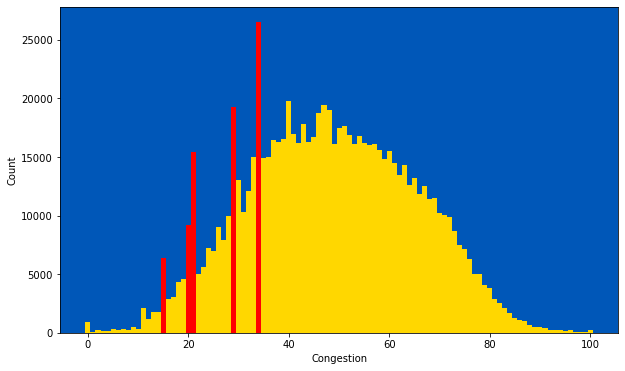

In [11]:
plt.figure(figsize=(10,6))
#plt.hist(train.congestion, bins = np.linespace(-0.5, 100.5, 102))
plt.bar(range(101), train.congestion.value_counts().sort_index(), width=1,
color = ['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in range(101)])
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()

Insight:

We need a deeper analysis in what contexts the values 15, 20, 21, 29, 34 are overrepresented.
It will be difficult to model this overrepresentation with a regression model. Maybe we need to invent special tricks to predict these values (if it is possible at all).
Let's drill down into some roadways to see whether the same values are overrepresented everywhere.

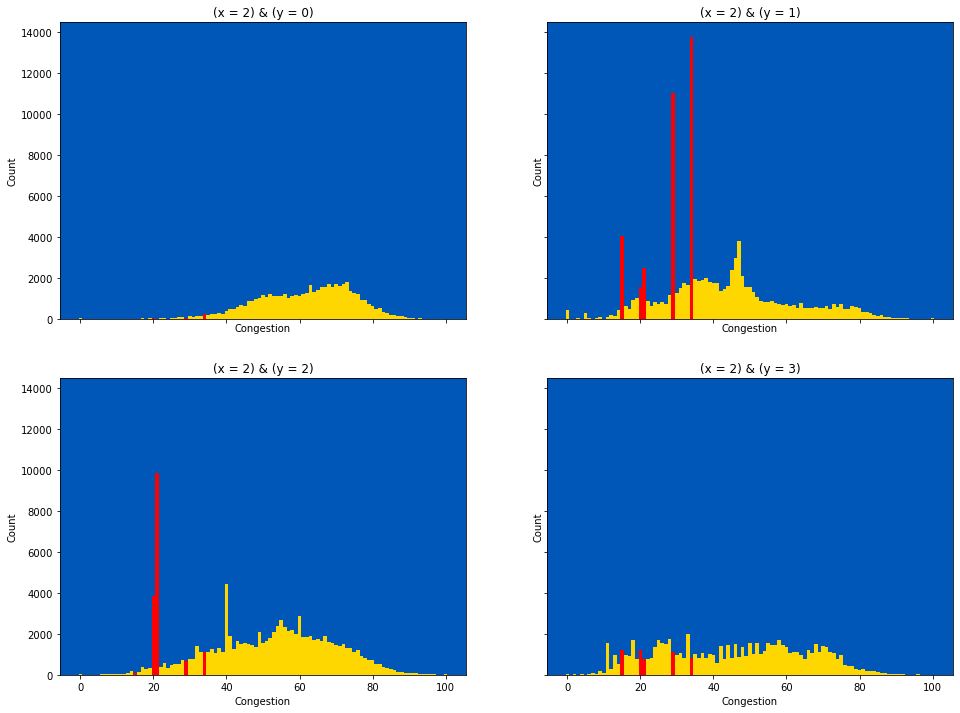

In [12]:
plt.subplots(2,2, sharex=True, sharey=True, figsize = (16, 12))
for y in range(4):
    plt.subplot(2,2, y+1)
    vc = train[(train.x ==2) & (train.y ==y)].congestion.value_counts()
    plt.bar(vc.index, vc, width=1, 
    color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in vc.index])
    plt.ylabel('Count')
    plt.xlabel('Congestion')
    plt.title(f"(x = {2}) & (y = {y})")
plt.show()

Obviously, congestions 15, 29 and 34 are a particularity of the roadway with x = 2 and y = 1. We'll drill down further, into the eight directions of this roadway, plotting all congestion values on a time axis, just to see that some of the directions have these special congestion values on every day of the six months of training data.

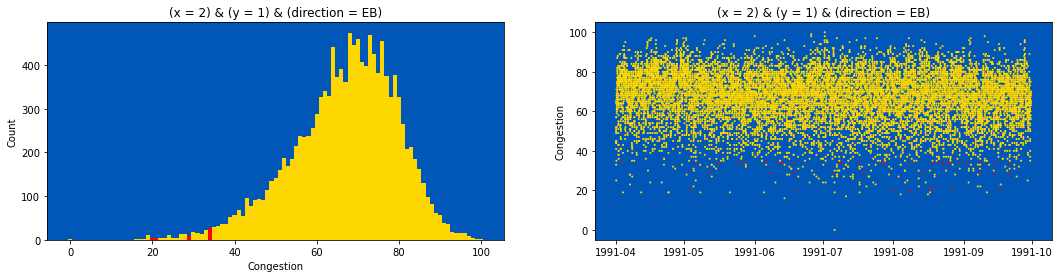

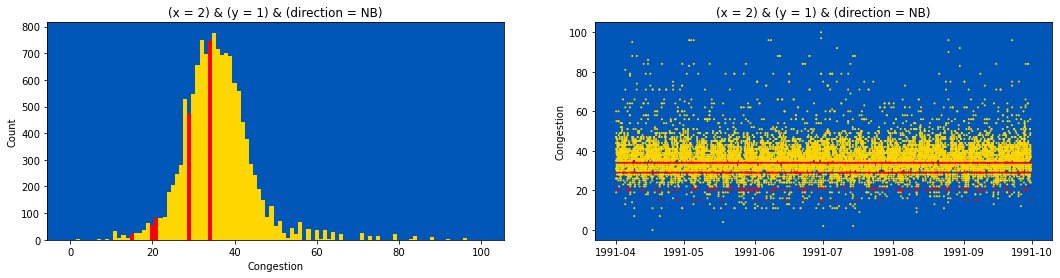

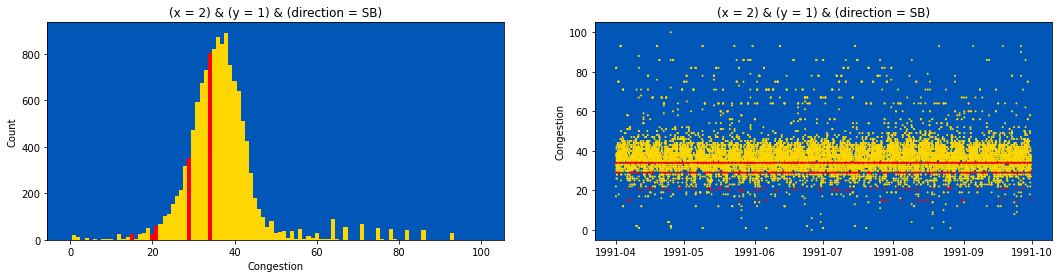

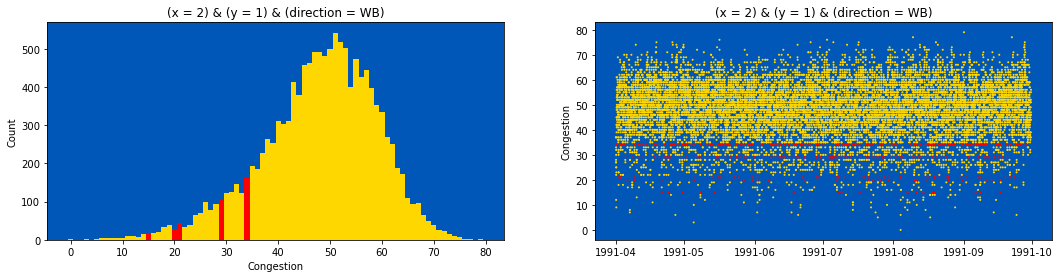

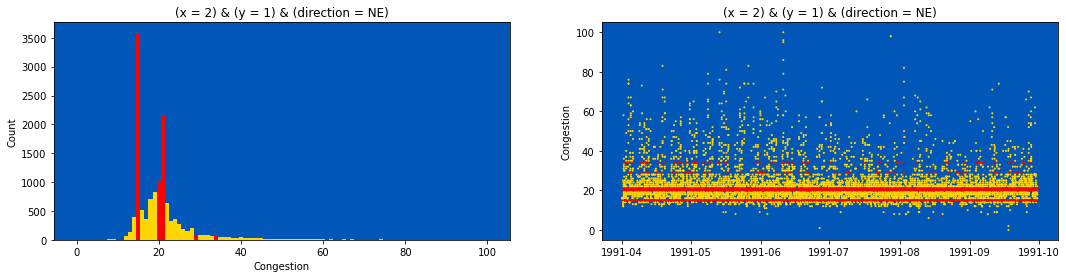

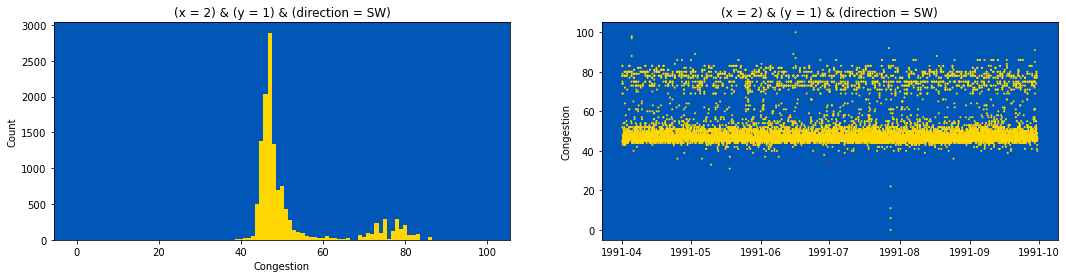

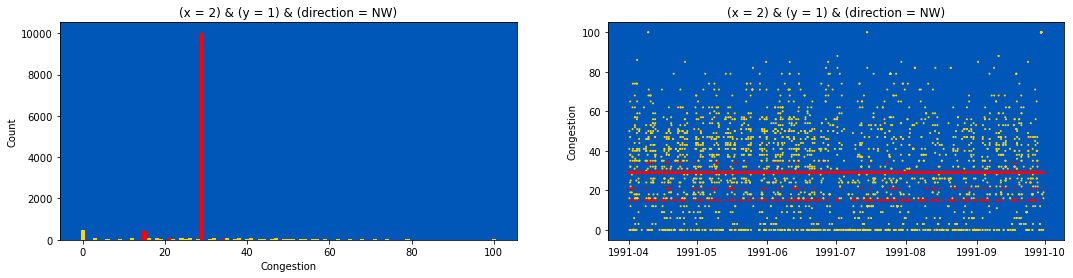

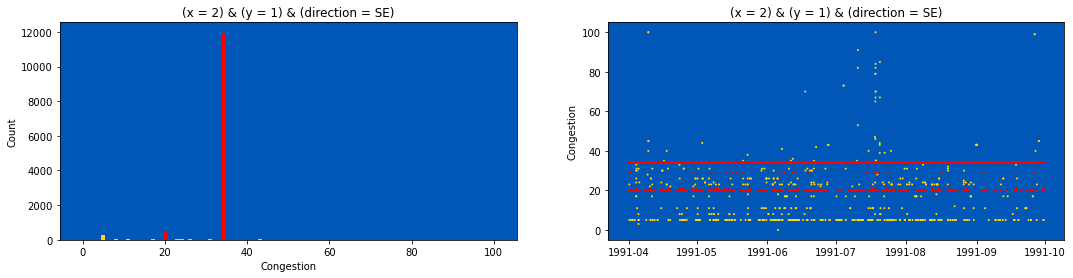

In [15]:
for direction in train.direction.unique():
    temp = train[(train.x == 2) & (train.y ==1) & (train.direction == direction)]
    plt.subplots(1, 2, figsize = (18,4))
    plt.subplot(1, 2, 1)
    vc = temp.congestion.value_counts().sort_index()
    plt.bar(vc.index, vc, width=1,
    color=['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in vc.index])
    plt.ylabel('Count')
    plt.xlabel('Congestion')
    plt.title(f"(x = {2}) & (y = {1}) & (direction = {direction})")
    plt.subplot(1, 2, 2)
    plt.scatter(temp.time, temp.congestion, s=1, color = ['r' if con in [15, 20, 21, 29, 34] else '#ffd700' for con in temp.congestion])
    plt.title(f"(x = {2}) & (y = {1}) & (direction = {direction})")
    plt.ylabel('Congestion')
    plt.show()

Insight: At this level of detail, the dataset no longer looks like something which a linear regression can fit. Decision trees may be the better choice for these data.

Dependence on time and date
We start by looking for a weekly pattern. As was to be expected, there is less traffic on weekends.

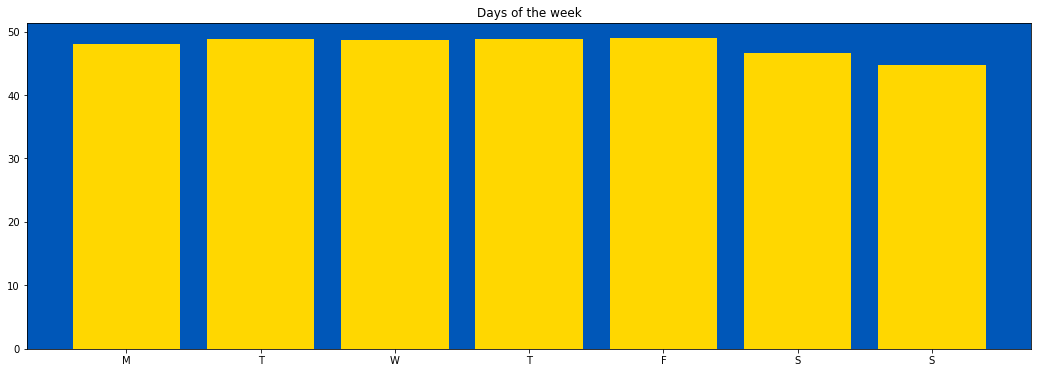

In [17]:
temp = train.groupby(train.time.dt.dayofweek).congestion.mean()
plt.figure(figsize=(18,6))
plt.title('Days of the week')
plt.bar(temp.index, temp, color = '#ffd700')
plt.xticks(ticks=temp.index, labels= 'MTWTFSS')
plt.show()

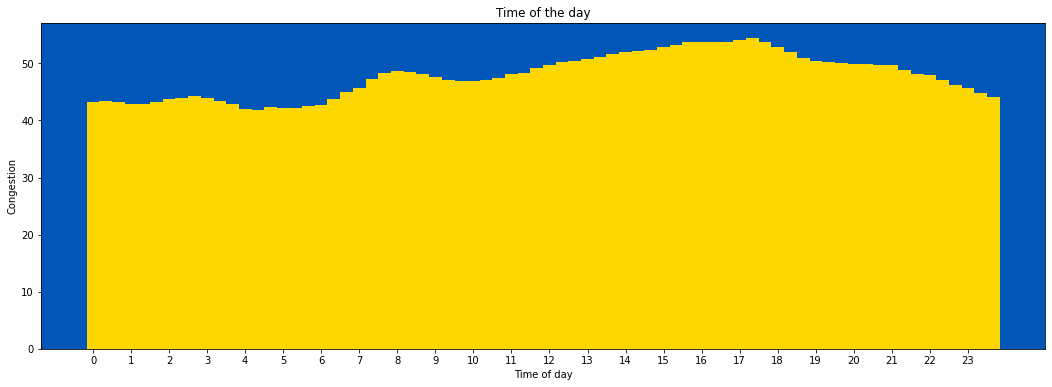

In [18]:
#Regarding a daily pattern; there is a daily pattern with a morning peak and a higher peak in the afternoon

temp = train.groupby(train.time.dt.hour + train.time.dt.minute/60).congestion.mean()
plt.figure(figsize = (18,6))
plt.title('Time of the day')
plt.bar(temp.index, temp, color= '#ffd700', width=0.34)
plt.xticks(range(24))
plt.xlabel("Time of day")
plt.ylabel('Congestion')
plt.show()

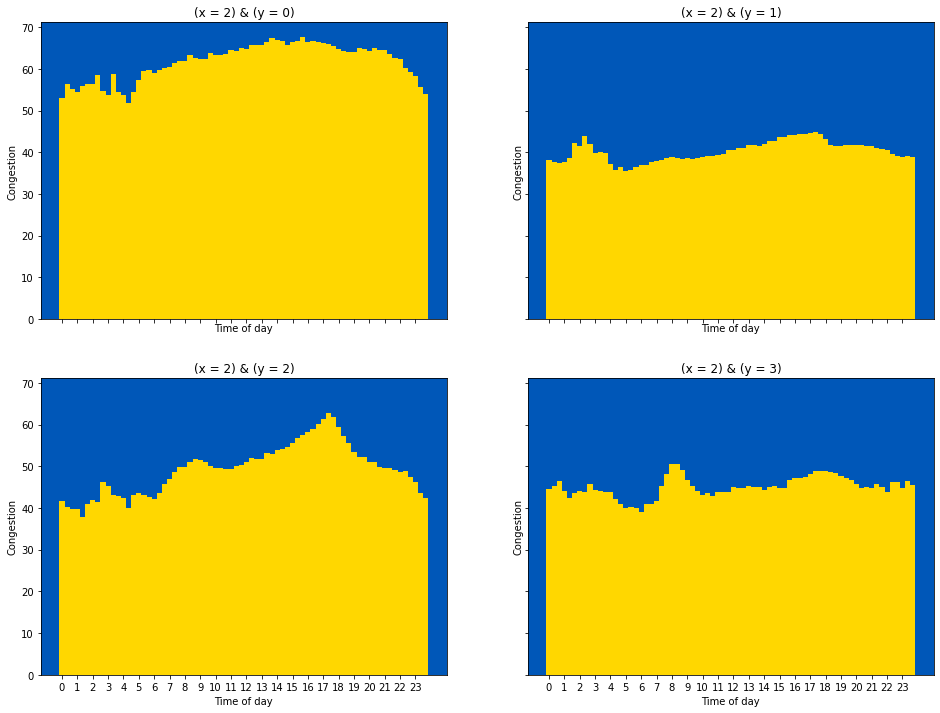

In [19]:
#When we drill further down, we see that every road has its own daily pattern:

plt.subplots(2,2, sharex = True, sharey=True, figsize = (16,12))
for y in range(4):
    plt.subplot(2,2, y+1)
    vc = train[(train.x == 2) & (train.y == y)]
    temp = vc.groupby(vc.time.dt.hour + vc.time.dt.minute/60).congestion.mean()
    plt.bar(temp.index, temp, color = '#ffd700', width = 0.34)
    plt.xticks(range(24))
    plt.xlabel('Time of day')
    plt.ylabel('Congestion')
    plt.title(f"(x = {2}) & (y = {y})")
plt.show()

If we plot the daily values for all days of the summer of 1991, we see more fluctuations:

The last week of April (the fifth week of the diagram) has exceptionally high traffic.
May 27 (Memorial Day) is a long weekend with little traffic on Monday.
The fourth of July (which was a Thursday) has exceptionally low traffic.
Labor day (September 2, the first Monday of September) has exceptionally low traffic.
The last two weekends in September look strange. Friday September 27 has very high traffic.
The rightmost bar of the diagram (Monday September 30) is quite low. This can probably be explained because the training data contains only the morning of this day (the afternoon is the test data).
Overall, there seem to be weeks with high traffic and weeks with low traffic.
(I used this calendar for looking up the holidays.)

Insight:

We will have to deal with outliers. A simple approach is dropping all the holidays before training.
If morning and afternoon of the same day are correlated, the morning of September 30 will play a special role in predicting the test afternoon.
We may need to find suitable external data to explain the high and low traffic weeks.
The worst case for our predictions will be if September 30 is a holiday or there is a big event which changes the traffic patterns.
A good validation strategy will be important. Perhaps we can use a few Monday afternoons as validation set.

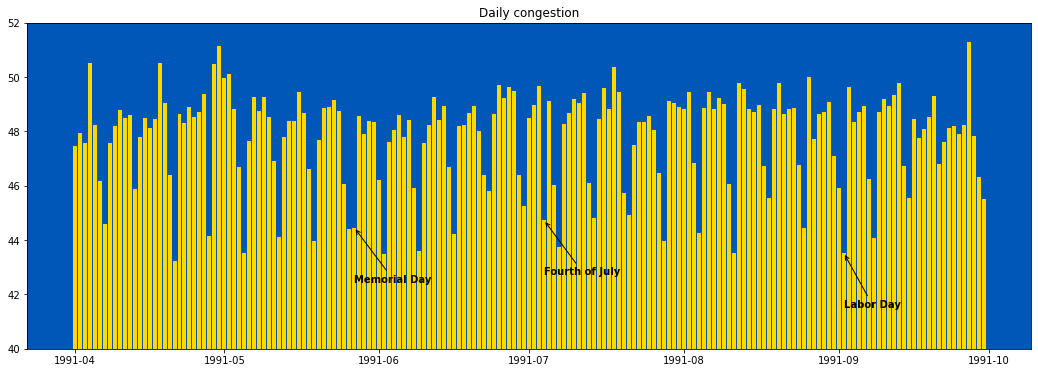

In [20]:
temp = train.groupby(train.time.dt.date).congestion.mean()
plt.figure(figsize=(18, 6))
plt.title('Daily congestion')
plt.bar(temp.index, temp, color='#ffd700')
plt.ylim(40, 52)
for holiday_name, month, day in [('Memorial Day', 5, 27), ('Fourth of July', 7, 4), ('Labor Day', 9, 2)]:
    date = datetime.date(1991, month, day)
    plt.annotate(holiday_name,
                 (np.datetime64(date), temp.loc[date]),
                 xytext=(np.datetime64(date), temp.loc[date]-2),
                 arrowprops={'arrowstyle': '->'},
                 weight='bold',
                 color='k')
plt.show()

Trend
We ca fit a linear regression to the daily averages to see if there is any significant growth during the six months. The diagram shows that the congestion grows by less than 0.2 over the whole period. I cannot yet tell whether this growth is significant.

Insight:

Considering that the total growth amounts to 0.2 and we are predicting integers, we may neglect growth for the beginning.

Before we include the trend as a feature in a model, we should test its significance.

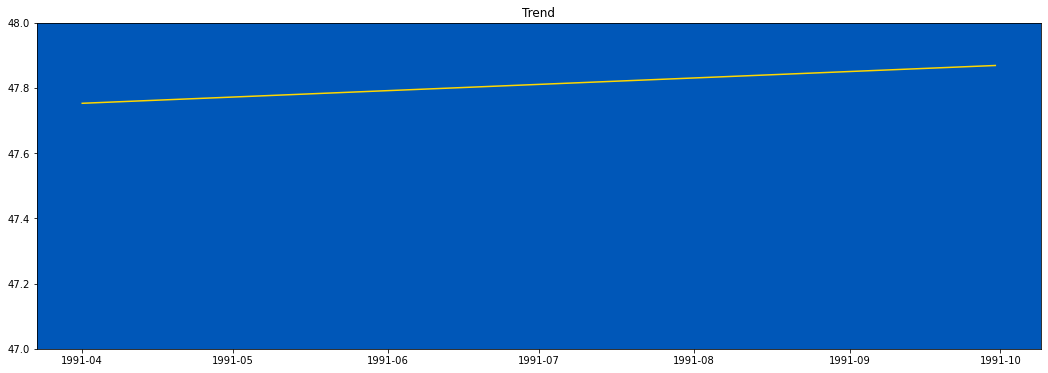

In [22]:
temp = train.groupby(train.time.dt.date).congestion.mean()
plt.figure(figsize=(18,6))
plt.title('Trend')
poly = np.polynomial.polynomial.Polynomial.fit(range(len(temp.index)), temp, deg=1)
plt.plot(temp.index, poly(range(len(temp.index))))
plt.ylim(47,48)
plt.show()

Alternative representations
The original dataframe has 848835 rows × 5 columns. The last column, congestion is the target, and every timestamp occurs 65 times. We can pivot the dataframe to get alternative representations, which may be helpful to create models:

We can pivot the dataframe so that all 13059 timestamps occur only once. The new dataframe has 65 target columns. We can interpret the 65 target columns as 65 independent univariate time series, or we can look at them as a single multivariate time series.

We can pivot the dataframe even more to get one row per day (i.e. 183 rows for the 183 days). This gives 4680 columns or 4680 independent time series.

In [23]:
#Original dataframe with single target column
pd.set_option("display.max_rows", 5, "display.max_columns", 15, "display.width", 120)
train

,time,x,y,direction,congestion
row_id,,,,,
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
...,...,...,...,...,...
848833,1991-09-30 11:40:00,2,3,SW,17
848834,1991-09-30 11:40:00,2,3,WB,24


In [24]:
# Pivoted dataframe with every timestamp occurring only once and 65 target columns
train.pivot(index=['time'], columns=['x', 'y', 'direction'])

congestion                          ...                            
x                            0                          ...   2                        
y                            0           1              ...   2   3                    
direction                   EB  NB  SB  EB  NB  SB  WB  ...  WB  EB  NB  NE  SB  SW  WB
time                                                    ...                            
1991-04-01 00:00:00         70  49  24  18  60  58  26  ...  51  39  64  30  70  29  26
1991-04-01 00:20:00         70  49  24  26  64  55  57  ...  58  33  67  30  80  29  57
..                         ...  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..
1991-09-30 11:20:00         52  36  59  35  67  54  26  ...  67  57  59  22  69  22  53
1991-09-30 11:40:00         70  40  51  24  65  52  42  ...  71  48  54  28  68  17  24

[13059 rows x 65 columns]

In [25]:
# Pivoted dataframe with one row per day and 4630 target columns
# Note that the afternoon of the last day has been filled with NaN
train2 = train.copy()
train2['date'] = train2.time.dt.date
train2['hour'] = train2.time.dt.hour
train2['minute'] = train2.time.dt.minute
train2.drop(columns=['time'], inplace=True)
train2.pivot(index=['date'], columns=['x', 'y', 'direction', 'hour', 'minute'])

congestion                                      ...                                          
x                   0                                      ...     2                                    
y                   0                 1                    ...     2     3                              
direction          EB    NB    SB    EB    NB    SB    WB  ...    WB    EB    NB    NE    SB    SW    WB
hour               0     0     0     0     0     0     0   ...    23    23    23    23    23    23    23
minute             0     0     0     0     0     0     0   ...    40    40    40    40    40    40    40
date                                                       ...                                          
1991-04-01       70.0  49.0  24.0  18.0  60.0  58.0  26.0  ...  68.0  55.0  67.0  25.0  64.0  13.0  39.0
1991-04-02       37.0  54.0  72.0  13.0  70.0  50.0  69.0  ...  62.0  61.0  65.0  25.0  69.0  19.0  50.0
..                ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...
1991-09-29       50.0  46.0  24.0  22.0  61.0  51.0  13.0  ...  55.0  42.0  70.0  25.0  79.0  11.0  27.0
1991-09-30       33.0  24.0  65.0  22.0  61.0  38.0  71.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN

[183 rows x 4680 columns]

Conclusion